# 2. Оптимальный тариф
Абонент хочет оптимизировать свои затраты на связь, сменив текущий тарифный план. Три оператора сотовой связи прислали свои предложения: описание всех тарифных планов агрегированы в единый документ. Имеется также выгрузка исходящих вызовов абонента за последние 6 месяцев.
Необходимо исследовать характер исходящих звонков абонента и предложить оптимальный тариф, обосновав свои рекомендации аналитическими расчетами. 

**Примечание:** начать исследование рекомендуется с описания начального набора данных.

## Начальное описание данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
df = pd.read_excel('data/calls.xlsx')

In [3]:
df.head(3)

,Дата звонка,Длительность разговора,Оператор связи вызываемого абонента
0,15.12.2010 10:50:54,00:01:49,билайн
1,15.12.2010 11:50:42,00:00:57,билайн
2,30.11.2010 16:39:34,00:00:55,билайн


In [4]:
df.columns = ['date', 'duration', 'target_operator']

In [5]:
df.dtypes

date               object
duration           object
target_operator    object
dtype: object

In [6]:
df.date = pd.to_datetime(df.date, dayfirst=True)
df.duration = pd.to_timedelta(df.duration)

In [7]:
df.head(3)

,date,duration,target_operator
0,2010-12-15 10:50:54,0 days 00:01:49,билайн
1,2010-12-15 11:50:42,0 days 00:00:57,билайн
2,2010-11-30 16:39:34,0 days 00:00:55,билайн


In [8]:
df['day_of_week'] = df.date.dt.day_name()
df['month'] = df.date.dt.month_name()
df['date'] = df.date.dt.date

In [9]:
df.head(3)

,date,duration,target_operator,day_of_week,month
0,2010-12-15,0 days 00:01:49,билайн,Wednesday,December
1,2010-12-15,0 days 00:00:57,билайн,Wednesday,December
2,2010-11-30,0 days 00:00:55,билайн,Tuesday,November


In [10]:
df.shape

(1230, 5)

Можно посмотреть на доли по операторам вызываемого абонента:

In [11]:
df.target_operator.value_counts(normalize=True).index

Index(['городской', 'билайн', 'мтс', 'смартс', 'мегафон', 'яртелеком',
       'теле 2', 'уралсвязьинфом'],
      dtype='object', name='target_operator')

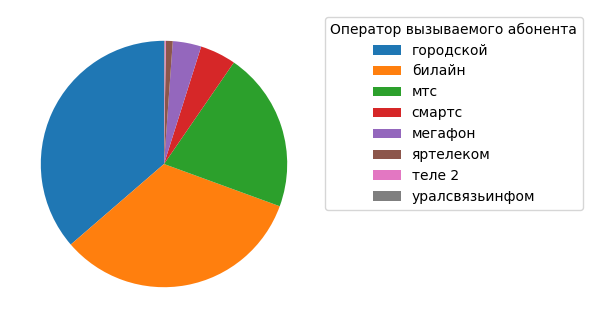

In [12]:
plt.figure(figsize=(8, 4))

plt.pie(df.target_operator.value_counts(), startangle=90)
plt.legend(df.target_operator.value_counts().index, title='Оператор вызываемого абонента', bbox_to_anchor=(1, 1))
plt.show()

На распределение по длительности звонка в секундах:

In [13]:
df['duration_seconds'] = df.duration.apply(lambda x: x.seconds)

In [14]:
df.head()

,date,duration,target_operator,day_of_week,month,duration_seconds
0,2010-12-15,0 days 00:01:49,билайн,Wednesday,December,109
1,2010-12-15,0 days 00:00:57,билайн,Wednesday,December,57
2,2010-11-30,0 days 00:00:55,билайн,Tuesday,November,55
3,2010-11-30,0 days 00:00:55,билайн,Tuesday,November,55
4,2010-12-01,0 days 00:06:47,билайн,Wednesday,December,407


In [15]:
df.duration_seconds.describe()

count    1230.000000
mean       97.062602
std       147.503809
min         1.000000
25%        22.000000
50%        48.000000
75%       105.000000
max      2188.000000
Name: duration_seconds, dtype: float64

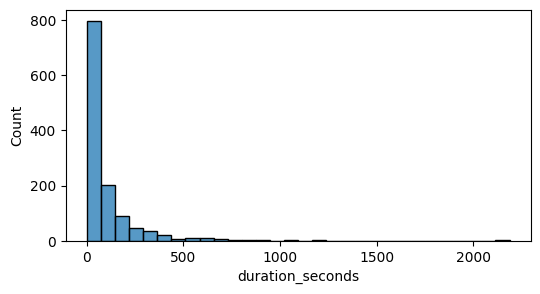

In [16]:
plt.figure(figsize=(6, 3))
sns.histplot(x='duration_seconds', data=df, bins=30)
plt.show()

In [17]:
df.duration_seconds.quantile(0.95)

352.54999999999995

In [18]:
round(stats.percentileofscore(df.duration_seconds, 600) / 100, 4)

0.9813

Видно, что подавляющее большинство звонков — $98,1\%$, по длительности не выходят из 10 минут, но пристуствуют выбросы.

In [19]:
df[df.duration_seconds > 600].shape[0]

23

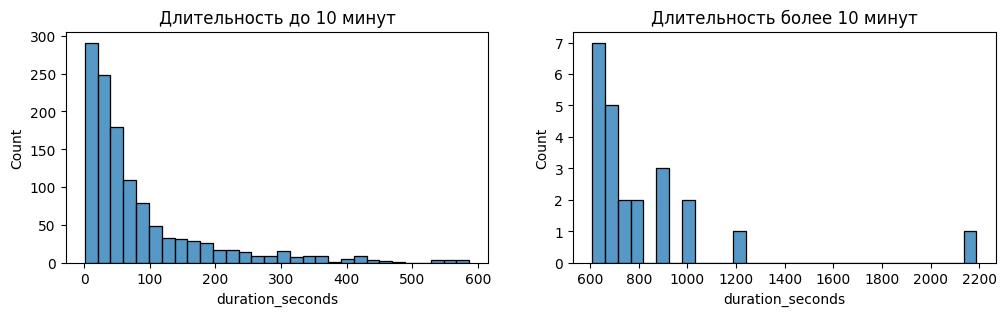

In [20]:
plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
sns.histplot(x='duration_seconds', data=df[df.duration_seconds <= 600], bins=30)
plt.title('Длительность до 10 минут')

plt.subplot(1, 2, 2)
sns.histplot(x='duration_seconds', data=df[df.duration_seconds > 600], bins=30)
plt.title('Длительность более 10 минут')

plt.show()

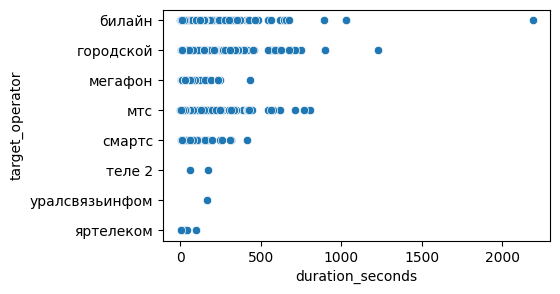

In [21]:
plt.figure(figsize=(5, 3))
sns.scatterplot(x='duration_seconds', y='target_operator', data=df)
plt.show()

По графику рассеяния практически ничего сказать нельзя, потому что некоторые операторы мало представлены.

Посмотрим также, как распределены звонки по меясцам и дням недели:

In [22]:
df = df.sort_values(by=['date'])

In [23]:
df.head(3)

,date,duration,target_operator,day_of_week,month,duration_seconds
1212,2010-07-01,0 days 00:00:11,смартс,Thursday,July,11
925,2010-07-01,0 days 00:01:43,мтс,Thursday,July,103
255,2010-07-01,0 days 00:00:17,билайн,Thursday,July,17


In [24]:
df.month.value_counts()

month
October      313
November     309
July         209
September    187
December     143
August        69
Name: count, dtype: int64

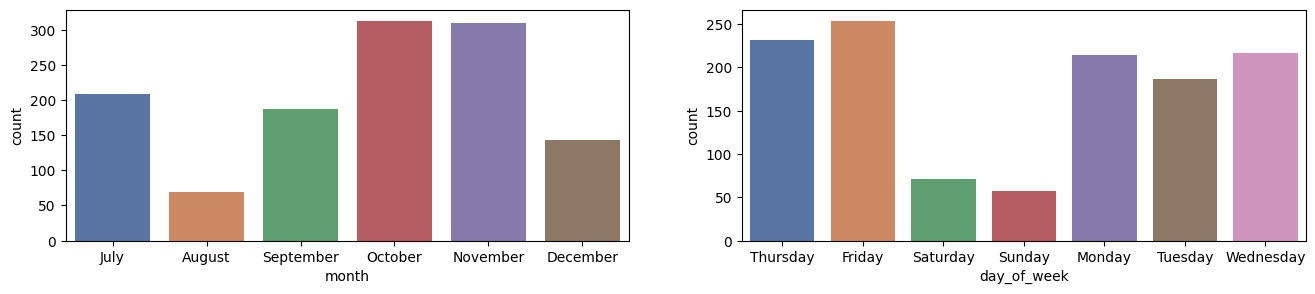

In [25]:
plt.figure(figsize=(16, 3))

plt.subplot(1, 2, 1)
sns.countplot(x='month', data=df, hue='month', palette='deep')

plt.subplot(1, 2, 2)
sns.countplot(x='day_of_week', data=df, hue='day_of_week', palette='deep')

plt.show()

## Вычисление стоимости тарифа

Суммарные траты по каждому из тарифов за 6 месяцев будем хранить в датафрейме:

In [26]:
costs_df = pd.DataFrame({
    'operator': ['Билайн', 'Билайн', 'Билайн', 'Мегафон', 'МТС'],
    'rate_name': ['Монстр общения', 'Хочу сказать', 'Больше слов', '33 копейки', 'Много звонков']
}, columns=['operator', 'rate_name', 'total_cost'])

In [27]:
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,NaN
1,Билайн,Хочу сказать,NaN
2,Билайн,Больше слов,NaN
3,Мегафон,33 копейки,NaN
4,МТС,Много звонков,NaN


### Билайн "Монстр общения"

Исходящие звонки:
- 1-ая минута: 1.50 рублей
- со 2-ой по 9-ую минуту: 0.50 рублей
- с 10-ой минуты: 1.00 рублей

In [28]:
df_beeline_1 = df[['duration_seconds', 'target_operator']].copy()
df_beeline_1['cost'] = 0 

In [29]:
df_beeline_1.head(3)

,duration_seconds,target_operator,cost
1212,11,смартс,0
925,103,мтс,0
255,17,билайн,0


In [30]:
def calc_cost_beeline_1(duration):
    """Функция для вычисления стоимости одного звонка по тарифу Монстр общения"""
    minutes = (duration + 59) // 60  # Округляем вверх до полной минуты
    cost = 0
    
    if minutes >= 1:
        cost += 1.50  # Первая минута
        
    if minutes > 1:
        # Со 2-й по 9-ю минуту
        additional_minutes = min(minutes - 1, 8)
        cost += additional_minutes * 0.50
    
    if minutes > 9:
        # С 10-й минуты
        cost += (minutes - 9) * 1.00
    
    return cost

In [31]:
df_beeline_1.cost = df_beeline_1.duration_seconds.apply(calc_cost_beeline_1)

In [32]:
df_beeline_1.head()

,duration_seconds,target_operator,cost
1212,11,смартс,1.5
925,103,мтс,2.0
255,17,билайн,1.5
1211,47,смартс,1.5
257,60,билайн,1.5


In [33]:
costs_df.iloc[0].total_cost = df_beeline_1.cost.sum()

In [34]:
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,2621.5
1,Билайн,Хочу сказать,NaN
2,Билайн,Больше слов,NaN
3,Мегафон,33 копейки,NaN
4,МТС,Много звонков,NaN


### Билайн "Хочу сказать"

Исходящие звонки:
- до пяти минут в день (включительно): 3.95 рублей
- с шестой минуты в день: 0.40 рублей

In [35]:
df_beeline_2 = df[['date', 'duration_seconds', 'target_operator']].copy()

In [36]:
df_beeline_2.head(3)

,date,duration_seconds,target_operator
1212,2010-07-01,11,смартс
925,2010-07-01,103,мтс
255,2010-07-01,17,билайн


In [37]:
def calc_cost_beeline_2(duration):
    minutes = (duration + 59) // 60  # Округляем вверх до полной минуты
    cost = 0

    cost += min(minutes, 5) * 3.95
    minutes -= 5

    if minutes > 0:
        cost += minutes * 0.40

    return cost

In [38]:
df_beeline_2 = df_beeline_2.groupby(['date'], as_index=False).duration_seconds.sum()

In [39]:
df_beeline_2.head()

,date,duration_seconds
0,2010-07-01,178
1,2010-07-02,556
2,2010-07-03,88
3,2010-07-04,123
4,2010-07-05,506


In [40]:
df_beeline_2['cost'] = df_beeline_2.duration_seconds.apply(calc_cost_beeline_2)

In [41]:
df_beeline_2.head()

,date,duration_seconds,cost
0,2010-07-01,178,11.85
1,2010-07-02,556,21.75
2,2010-07-03,88,7.90
3,2010-07-04,123,11.85
4,2010-07-05,506,21.35


In [42]:
costs_df.iloc[1].total_cost = df_beeline_2.cost.sum()

In [43]:
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,2621.5
1,Билайн,Хочу сказать,2867.2
2,Билайн,Больше слов,NaN
3,Мегафон,33 копейки,NaN
4,МТС,Много звонков,NaN


### Билайн "Больше слов"
Фиксированная плата в месяц — 555 рублей за пакет из 555 минут, после исчерпания пакета — 1.95 рублей минута.

In [44]:
df.head(3)

,date,duration,target_operator,day_of_week,month,duration_seconds
1212,2010-07-01,0 days 00:00:11,смартс,Thursday,July,11
925,2010-07-01,0 days 00:01:43,мтс,Thursday,July,103
255,2010-07-01,0 days 00:00:17,билайн,Thursday,July,17


In [45]:
df_beeline_3 = df[['month', 'duration_seconds', 'target_operator']].copy()

In [46]:
df_beeline_3.head(3)

,month,duration_seconds,target_operator
1212,July,11,смартс
925,July,103,мтс
255,July,17,билайн


In [47]:
df_beeline_3 = df_beeline_3.groupby(['month'], as_index=False).duration_seconds.sum()

In [48]:
def calc_cost_beeline_3(duration):
    minutes = (duration + 59) // 60  # Округляем вверх до полной минуты
    cost = 555

    over_mins = max(minutes - 555, 0)
    cost += over_mins * 1.95

    return cost

In [49]:
df_beeline_3['cost'] = df_beeline_3.duration_seconds.apply(calc_cost_beeline_3)

In [50]:
costs_df.iloc[2].total_cost = df_beeline_3.cost.sum()

In [51]:
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,2621.5
1,Билайн,Хочу сказать,2867.2
2,Билайн,Больше слов,3441.15
3,Мегафон,33 копейки,NaN
4,МТС,Много звонков,NaN


### Мегафон "33 копейки"
Исходящие вызовы:
- 1-ая минута: 1.00 руб/минута
- со 2-ой минуты: 0.33 руб/минута

In [52]:
df_megafon = df[['duration_seconds']].copy()

In [53]:
def calc_cost_megafon(duration):
    minutes = (duration + 59) // 60  # Округляем вверх до полной минуты
    cost = 0

    if minutes >= 1:
        cost += 1.00

    if minutes > 1:
        cost += (minutes - 1) * 0.33

    return cost

In [54]:
df_megafon.head(3)

,duration_seconds
1212,11
925,103
255,17


In [55]:
df_megafon['cost'] = df_megafon.duration_seconds.apply(calc_cost_megafon)

In [56]:
costs_df.iloc[3].total_cost = df_megafon.cost.sum()

In [57]:
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,2621.5
1,Билайн,Хочу сказать,2867.2
2,Билайн,Больше слов,3441.15
3,Мегафон,33 копейки,1699.59
4,МТС,Много звонков,NaN


### МТС "Много звонков"
Исходящие звонки:
- до 5 минут в день (включительно) и с 31-ой минуты в день: 0.90 руб/мин
- c 6-ой по 30-ую минуты (включительно) в день: 0.05 руб/мин

In [58]:
df_mts = df[['date', 'duration_seconds']].copy()

In [59]:
df_mts = df_mts.groupby(['date'], as_index=False).duration_seconds.sum()

In [60]:
df_mts.head(3)

,date,duration_seconds
0,2010-07-01,178
1,2010-07-02,556
2,2010-07-03,88


In [61]:
def calc_cost_mts(duration):
    minutes = (duration + 59) // 60  # Округляем вверх до полной минуты
    cost = 0

    if minutes <= 5:
        cost = minutes * 0.90
    elif minutes <= 30:
        cost = 5 * 0.90 + (minutes - 5) * 0.05
    else:
        cost = 5 * 0.90 + (30 - 5) * 0.05 + (minutes - 30) * 0.90

    return cost

In [62]:
df_mts['cost'] = df_mts.duration_seconds.apply(calc_cost_mts)

In [63]:
df_mts[df_mts.duration_seconds > 1800].shape

(18, 3)

In [64]:
costs_df.iloc[4].total_cost = df_mts.cost.sum()
costs_df

,operator,rate_name,total_cost
0,Билайн,Монстр общения,2621.5
1,Билайн,Хочу сказать,2867.2
2,Билайн,Больше слов,3441.15
3,Мегафон,33 копейки,1699.59
4,МТС,Много звонков,834.65


## Вывод

In [65]:
left, right = 60 * 5, 60 * 30
df_mts.query('duration_seconds >= @left and duration_seconds < @right').shape[0] / df_mts.shape[0]

0.5615384615384615

Таким образом, получается, что абоненту выгоднее всего выбрать для себя тариф "Много звонков" от МТС, если ориентироваться только на характер его исходящих звонков за последние 6 месяцев. Это связано с тем, что большинство дней абонент по использованым минутам попадает в самый выгодный интервал от 6 до 30 минут.